In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

import numpy as np

from src.dataset import load_dataset_train_test
from src.models import optimal_model_builder_ch_2_11
from src.cfd import CFD, find_optimal_cfd_threshold
from src.network_utils import train_model as _base_train_model, plot_difference_hist, plot_history, compare_results

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PLANE = 2
CHANNEL = 11

PRINT_PCOV = False

N_BASELINE = 8

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 3000
BATCH_SIZE = 2048
LOSS_WEIGHT = 1000

In [3]:
X_train, X_test, y_train, y_test = load_dataset_train_test(PWD, PLANE, CHANNEL)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22412, 24), (5603, 24), (22412,), (5603,))

In [4]:
x_time = np.arange(0, 24 / 7.695, 1 / 7.695)
x_time.shape

(24,)

# Utils

In [5]:
def train_model(model, name, X_train=X_train, y_train=y_train, X_val=X_test, y_val=y_test, lr=LR, train=False,
                n_epochs=N_EPOCHS, verbose=1, batch_size=BATCH_SIZE, lr_patience=10, es_patience=60,
                es_min_delta=ES_MIN_DELTA, loss_weight=LOSS_WEIGHT):
    return _base_train_model(model, name, 'base_results', X_train, y_train, X_val, y_val, lr, train, n_epochs, verbose,
                             batch_size, lr_patience, es_patience, es_min_delta, loss_weight, root=PWD + '/data')

# CFD

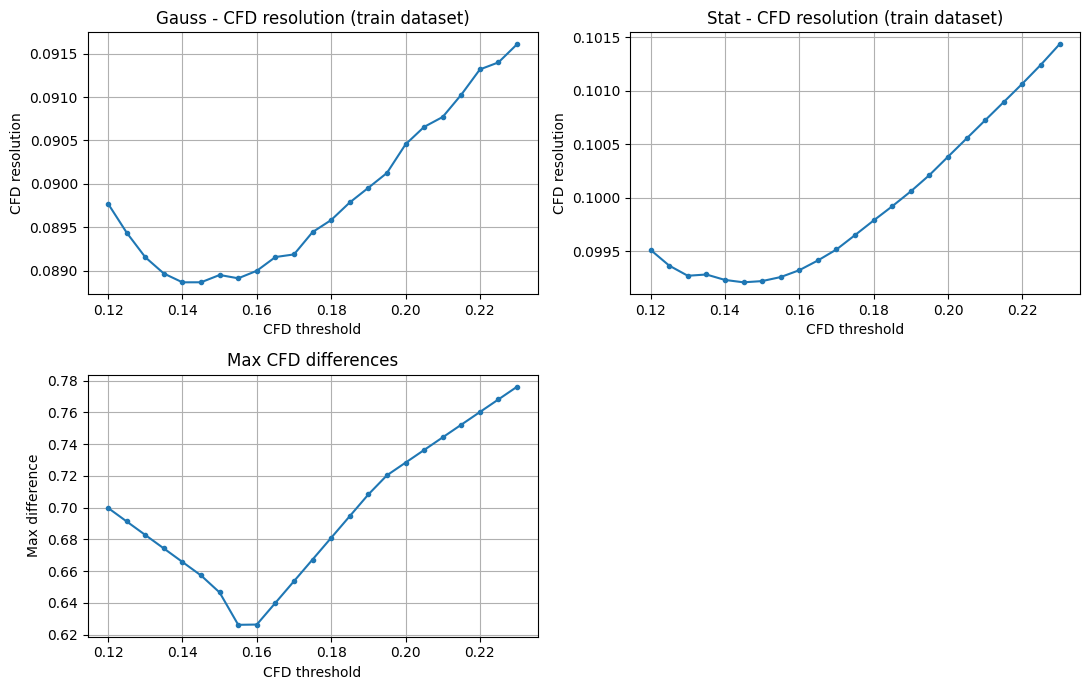

Optimal CFD threshold: 0.145


In [6]:
thresholds = np.arange(0.12, 0.23, 0.005)
optimal_cfd_threshold = find_optimal_cfd_threshold(thresholds, N_BASELINE, X_train, y_train, x_time, n_jobs=16)

In [7]:
cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_threshold)

y_pred = cfd.predict(x_time, X_test)

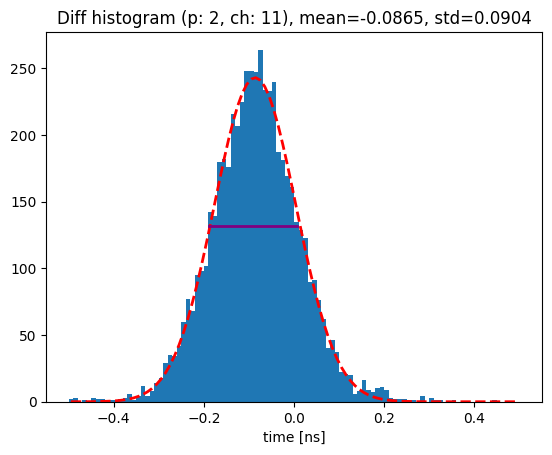

In [8]:
std_cfd_hist, pcov, fwhm_cfd = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_cfd_stat = np.std(y_pred - y_test)

# Optimal model

In [9]:
model = optimal_model_builder_ch_2_11()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 24)               96        
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 24, 32)            128       
                                                                 
 batch_normalization_1 (Batc  (None, 24, 32)           128       
 hNormalization)                                                 
                                                                 
 spatial_dropout1d (SpatialD  (None, 24, 32)           0         
 ropout1D)                                                       
                                                        

In [10]:
history = train_model(model, "optimal", y_train=y_train, y_val=y_test, train=True)

Epoch 1/3000
11/11 [==============================] - 4s 30ms/step - loss: 2173.7368 - val_loss: 675.9120 - lr: 0.0100
Epoch 2/3000
11/11 [==============================] - 0s 11ms/step - loss: 689.0453 - val_loss: 272.9628 - lr: 0.0100
Epoch 3/3000
11/11 [==============================] - 0s 11ms/step - loss: 333.8064 - val_loss: 89.9879 - lr: 0.0100
Epoch 4/3000
11/11 [==============================] - 0s 11ms/step - loss: 222.0684 - val_loss: 68.1093 - lr: 0.0100
Epoch 5/3000
11/11 [==============================] - 0s 7ms/step - loss: 167.6594 - val_loss: 75.5686 - lr: 0.0100
Epoch 6/3000
11/11 [==============================] - 0s 10ms/step - loss: 137.0521 - val_loss: 50.8409 - lr: 0.0100
Epoch 7/3000
11/11 [==============================] - 0s 10ms/step - loss: 113.6938 - val_loss: 44.5852 - lr: 0.0100
Epoch 8/3000
11/11 [==============================] - 0s 10ms/step - loss: 93.6035 - val_loss: 38.6187 - lr: 0.0100
Epoch 9/3000
11/11 [==============================] - 0s 11ms/s

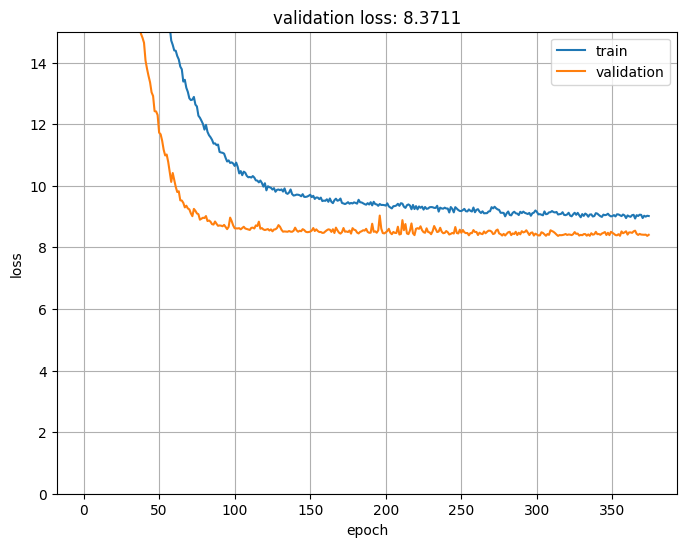

In [11]:
plot_history(history, ymax=15)

176/176 [==============================] - 0s 1ms/step


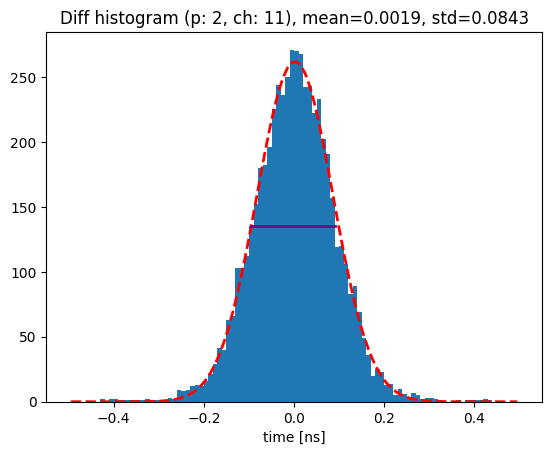

In [12]:
y_pred = model.predict(X_test)[:, 0]
std_hist_model, pcov, fwhm_model = plot_difference_hist(y_test, y_pred, PLANE, CHANNEL, print_pcov=PRINT_PCOV)
std_stat_model = np.std(y_pred - y_test)

# Compare standard deviations

### Difference histogram – Gauss

In [13]:
compare_results([std_hist_model], ["Optimal NN model"], std_cfd_hist)

       CFD: 90.39 ps
Optimal NN model: 84.33 ps (improvement: 6.70 %)


### Stat

In [14]:
compare_results([std_stat_model], ["Optimal NN model"], std_cfd_stat)

       CFD: 99.28 ps
Optimal NN model: 91.49 ps (improvement: 7.85 %)


### Full width at half maximum (FWHM)

In [15]:
compare_results([fwhm_model], ["Optimal NN model"], fwhm_cfd)

       CFD: 194.92 ps
Optimal NN model: 184.32 ps (improvement: 5.44 %)
